# Carbon emissions
This notebook analyzes carbon emissions through time, across countries and industries.
---



Data source = Carbon Monitor: https://carbonmonitor.org, it's an amazing resource

In [94]:
import pandas as pd          # This library is for data wrangling
import seaborn as sns        # This is one library for plotting
import plotly.express as px  # This is another library for plots 

url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data = pd.read_csv(url, skiprows = 0)
data['date'] = pd.to_datetime(data['date'],format='%d/%m/%Y') # Correct date format
data

,country,date,sector,value,timestamp
0,Brazil,2019-01-01,Power,0.108768,1546272000
1,China,2019-01-01,Power,14.251000,1546272000
2,EU27 & UK,2019-01-01,Power,1.676920,1546272000
3,France,2019-01-01,Power,0.049075,1546272000
4,Germany,2019-01-01,Power,0.349691,1546272000
...,...,...,...,...,...
76603,Russia,2021-06-30,International Aviation,0.020850,1624982400
76604,Spain,2021-06-30,International Aviation,0.028848,1624982400
76605,UK,2021-06-30,International Aviation,0.028976,1624982400
76606,US,2021-06-30,International Aviation,0.140004,1624982400


This data is sampled at the daily frequency: that's a lot!
Let us aggregate the values into monthly emissions. 
This can be done with pivot tables.


In [106]:
data['year'] = pd.DatetimeIndex(data['date']).year   # First add year
data['month'] = pd.DatetimeIndex(data['date']).month # & add month
data['year_month'] = data['year'].astype(str).str.cat(data['month'].astype(str))

data_m = data.pivot_table(values=['value'], aggfunc='sum', index=['country', 'sector', 'year', 'month', 'year_month']).reset_index()
data_m['day'] = 15                                   # Say, middle of the month..
data_m['date'] = pd.to_datetime(data_m[['year', 'month', 'day']])
data_m

,country,sector,year,month,year_month,value,day,date
0,Brazil,Domestic Aviation,2019,1,20191,0.969131,15,2019-01-15
1,Brazil,Domestic Aviation,2019,2,20192,0.801970,15,2019-02-15
2,Brazil,Domestic Aviation,2019,3,20193,0.834112,15,2019-03-15
3,Brazil,Domestic Aviation,2019,4,20194,0.769131,15,2019-04-15
4,Brazil,Domestic Aviation,2019,5,20195,0.739430,15,2019-05-15
...,...,...,...,...,...,...,...,...
2515,WORLD,Residential,2021,2,20212,440.018200,15,2021-02-15
2516,WORLD,Residential,2021,3,20213,363.678140,15,2021-03-15
2517,WORLD,Residential,2021,4,20214,281.703960,15,2021-04-15
2518,WORLD,Residential,2021,5,20215,204.834200,15,2021-05-15


# Country focus
Let's zoom briefly on one country, say, the US.

In [107]:
data_m[data_m['country']=="US"]

,country,sector,year,month,year_month,value,day,date
2160,US,Domestic Aviation,2019,1,20191,13.465002,15,2019-01-15
2161,US,Domestic Aviation,2019,2,20192,12.865129,15,2019-02-15
2162,US,Domestic Aviation,2019,3,20193,14.441102,15,2019-03-15
2163,US,Domestic Aviation,2019,4,20194,14.169614,15,2019-04-15
2164,US,Domestic Aviation,2019,5,20195,15.004223,15,2019-05-15
...,...,...,...,...,...,...,...,...
2335,US,Residential,2021,2,20212,89.022220,15,2021-02-15
2336,US,Residential,2021,3,20213,62.583360,15,2021-03-15
2337,US,Residential,2021,4,20214,41.038089,15,2021-04-15
2338,US,Residential,2021,5,20215,28.938996,15,2021-05-15


Now let's have a look!

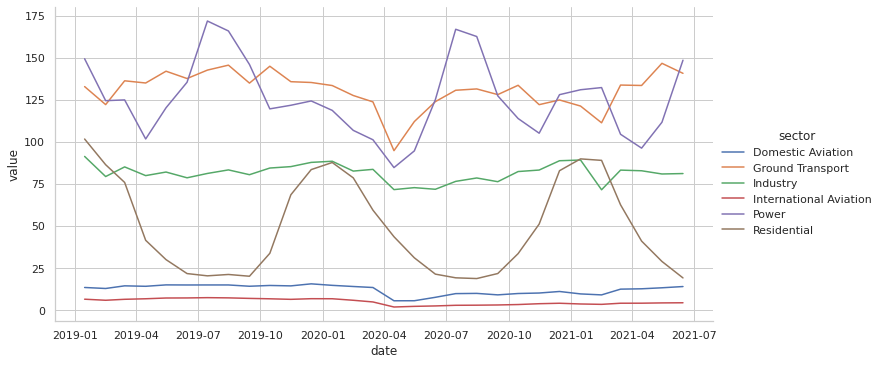

In [108]:
sns.set_style("whitegrid")
sns.relplot(
    data = data_m.query('country == "US"'),   # Data source = the filtered data (other method)
    kind = "line",                            # Graph type = line
    x = "date",                               # x-axis = Date column (of course!)
    y = "value",                              # y-axis = the normalised Close column
    hue = "sector",                           # One color for each sector
    aspect = 2
)


How about in relative terms?

In [115]:
data_m_US = data_m.query('country == "US"').reset_index() # Intermediate dataset
data_m_US['rel_value'] = data_m_US.groupby('date')['value'].transform(lambda x: x/sum(x))

fig = px.bar(data_m_US, 
             x = "date", 
             y = "rel_value", 
             color = "sector", 
             title = "Relative emissions")
fig.show()

# Cross-country analysis
Now, let's compare country emissions.  
We aggregate all sectors to ease the visualization.   
This requires a new pivot table.   


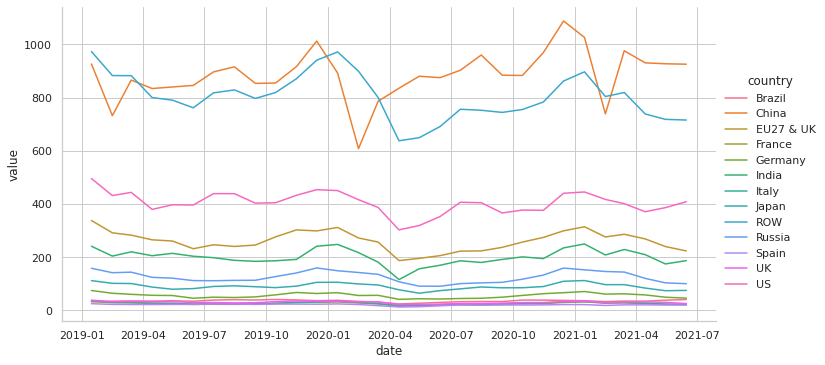

In [119]:
data_country = data_m.pivot_table(values = 'value', aggfunc = 'sum', index = ['country', 'date']).reset_index()
sns.set_style("whitegrid")
sns.relplot(
    data = data_country.query('country != "WORLD"'),   # Data source = the filtered data (other method)
    kind = "line",                            # Graph type = line
    x = "date",                               # x-axis = Date column (of course!)
    y = "value",                              # y-axis = the normalised Close column
    hue = "country",                           # One color for each sector
    aspect = 2
)

The blue line above ROW = *rest of the world*.  
The three main emitters are China, the US and Europe.